In [1]:
!tar -xzf /kaggle/input/task-s/binding_affinity_data.tar.xz
!pip install pylcs blosum torcheval --quiet

In [2]:
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import pylcs
DEVICE = 'cuda'

In [3]:
df = pd.read_csv('/kaggle/working/binding_affinity_data.csv')

In [5]:
df_custom = df[df['MHC_type'] == 'HLA-B*27:05']

In [6]:
amino_acids = list(sorted(set(''.join(df['peptide_sequence'].tolist())))) + ['-', '*']
aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}
START_TOKEN = aa_to_idx['*']
PEPTIDE_LEN = 15
def encode(peptide_str):
    return [START_TOKEN] + [aa_to_idx[peptide_str[i]] if i < len(peptide_str) else aa_to_idx['-']  for i in range(PEPTIDE_LEN - 1)]

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X = torch.tensor(np.stack(df_custom['peptide_sequence'].apply(lambda t: np.array(encode(t))).to_numpy()), device=DEVICE)
Y = torch.tensor(df_custom['label'].to_numpy(), device=DEVICE)

perm = torch.randperm(X.shape[0])
TRAIN_SIZE = int(0.9 * X.shape[0])
BATCH_SIZE = 1024

training_data = TensorDataset(X[perm][:TRAIN_SIZE], Y[perm][:TRAIN_SIZE])
val_data = TensorDataset(X[perm][TRAIN_SIZE:], Y[perm][TRAIN_SIZE:])

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
import blosum as bl
matrix = bl.BLOSUM(62)
bl_embedding = torch.stack(
    [torch.tensor([x[1] for x in sorted(matrix[a].items())[1:]]) for a in amino_acids[:-2]]
    + [torch.tensor([0. for i in range(-1 + len(matrix["A"].items()))])]
).to(DEVICE)
bl_embedding.shape

torch.Size([21, 24])

In [46]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len = 14):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.squeeze(1))

    def forward(self, x):
        x = x + self.pe[:x.size(1)].unsqueeze(0)
        return x

    
class Block(nn.Module):
    def __init__(self, embed_dim=32, num_heads=4, *args, **kwargs):
        super(Block, self).__init__()
        self.ln_1 = nn.LayerNorm(embed_dim)

        self.kw, self.qw, self.vw = nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim), nn.Linear(embed_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        self.ln_2 = nn.LayerNorm(embed_dim)

        self.c_fc    = nn.Linear(embed_dim, 4 * embed_dim)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * embed_dim, embed_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.ln_1(x)
        x = x + self.attn(self.qw(x), self.kw(x), self.vw(x))[0]
        x = self.ln_2(x)
        x = x + self.dropout(self.c_proj(self.gelu(self.c_fc(x))))
        return x
    
class BaseModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super(BaseModel, self).__init__()
        EMB = 32
        self.pre = nn.Sequential(
            nn.Embedding(len(amino_acids), EMB), # .from_pretrained(bl_embedding),
            PositionalEncoding(EMB, max_len=PEPTIDE_LEN),
            # nn.Linear(24, 32),
            nn.Tanh(),
            *[Block(embed_dim=EMB) for i in range(4)]
        )
        self.head_1 = nn.Sequential(
            nn.Linear(EMB, 8),
            # nn.Linear(PEPTIDE_LEN * 8, 64),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.Linear(8, 32),
            nn.ReLU()
        )
        self.head_2 = nn.Sequential(
            nn.BatchNorm1d(32),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.Linear(8, 1)
        )
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.pre(x)
        return self.sig(
            self.head_2(
                x[:, 0, :].squeeze(1) + self.head_1(x[:, 0, :].squeeze(1))
            )
        )

model = BaseModel().to(DEVICE)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.BCELoss(reduction='none')
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience=3, verbose=True)

65113


In [10]:
from torcheval.metrics.functional import binary_f1_score, binary_precision, binary_recall, binary_auroc

def val_model(model, dataloader):
    model.eval()
    val_loss = 0
    results = []
    targets = []
    with torch.no_grad():
        for x, target in dataloader:
            res = model(x)
            results.append(res)
            targets.append(target)
            val_loss += nn.BCELoss(reduction='sum')(res.reshape(-1), target.reshape(-1).float()).item()
    
    res = torch.concat(results).reshape(-1)
    target = torch.concat(targets)
    accuracy = (res.reshape(-1).round() == target.reshape(-1)).float().mean().item()
    val_loss /= len(val_dataloader.dataset)
    return val_loss, accuracy, binary_auroc(res, target).item(), binary_precision(res, target).item(), binary_recall(res, target).item(), binary_f1_score(res, target).item()
# binary_f1_score(res, target).item(), binary_precision(res, target).item(), binary_recall(res, target).item()

In [47]:
running_loss = []
running_val_loss = []
running_val_loss_idx = []
running_acc = []
running_auroc = []
running_percision = []
running_recall = []
running_f1 = []
upds = 0

In [50]:
epochs = 16
for i in range(epochs):
    for x, target in tqdm(train_dataloader):
        model.train()
        res = model(x)
        loss = (loss_fn(res.reshape(-1), target.reshape(-1).float())).mean() # * class_w[target]).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
        upds += 1
        if upds % 100 == 0:
            val_loss, accuracy, auroc, percision, recall, f1 = val_model(model, val_dataloader)
            running_val_loss.append(val_loss)
            running_acc.append(accuracy)
            running_auroc.append(auroc)
            running_percision.append(percision)
            running_recall.append(recall)
            running_f1.append(f1)
            running_val_loss_idx.append(upds)
            scheduler.step(f1)
        if i % 5 == 0:
            PATH = f"model-{i}.pt"
            torch.save({
                'epoch': i,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, PATH
            )

 89%|████████▉ | 143/161 [00:05<00:00, 23.08it/s]

Epoch 00040: reducing learning rate of group 0 to 1.0000e-02.


 84%|████████▍ | 135/161 [00:04<00:01, 21.62it/s]

Epoch 00048: reducing learning rate of group 0 to 1.0000e-03.


100%|██████████| 161/161 [00:08<00:00, 18.57it/s]


0.7280360460281372
0.9179251454615135


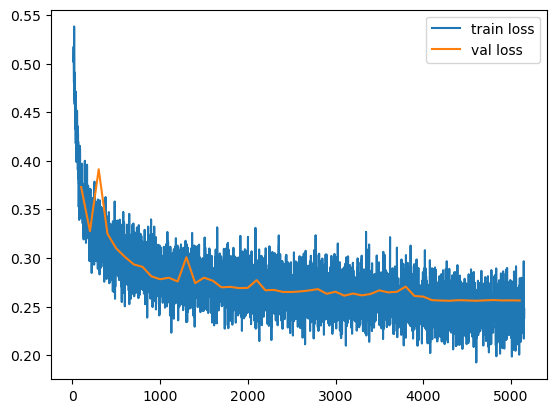

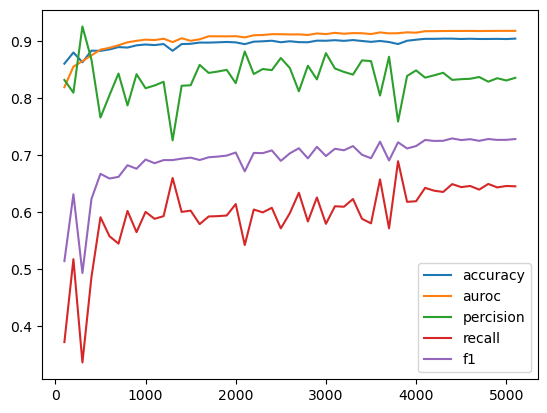

In [53]:
print(running_f1[-1])
print(running_auroc[-1])
plt.plot(np.arange(len(running_loss))[10:], running_loss[10:], label="train loss")
plt.plot(running_val_loss_idx, running_val_loss, label="val loss")
plt.legend()
plt.show()
plt.plot(running_val_loss_idx, running_acc, label="accuracy")
plt.plot(running_val_loss_idx, running_auroc, label="auroc")
plt.plot(running_val_loss_idx, running_percision, label="percision")
plt.plot(running_val_loss_idx, running_recall, label="recall")
plt.plot(running_val_loss_idx, running_f1, label="f1")
plt.legend()
plt.show()

In [34]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X = torch.tensor(np.stack(df['peptide_sequence'].apply(lambda t: np.array(encode(t))).to_numpy()), device=DEVICE)
Y = torch.tensor(df['label'].to_numpy(), device=DEVICE)
TEST_BATCH_SIZE = 2048

def get_mhc_dataloader(mhc_type):
    mask = df['MHC_type'] == mhc_type
    dataset = TensorDataset(X[mask], Y[mask])
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
mhc_type_to_seq = {df['MHC_type'][i]: df['MHC_sequence'][i] for i in range(len(df))}

In [36]:
import pylcs

mhc = df['MHC_type'].unique().tolist()
N = len(mhc)
adj = np.zeros((N, N))

for i in range(N):
    a = mhc_type_to_seq[mhc[i]]
    for j in range(i, N):
        b = mhc_type_to_seq[mhc[j]]
        common = pylcs.lcs_sequence_length(a, b)
        min_len = min(len(a), len(b))
        adj[i][j] = common / min_len
        adj[j][i] = common / min_len

In [54]:
ind = mhc.index('HLA-B*27:05')
most_similars = np.argsort(adj[ind])[::-1]
print("type\tsimilarity\tval_loss\taccuracy\tauroc\tpercision\trecall\tf1\tcount")
for i, x in enumerate(most_similars[:5]):
    dataloader = get_mhc_dataloader(mhc[x])
    print('\t'.join([mhc[x], str(np.round(adj[0][x], decimals=3))] + [str(np.round(t, decimals=3)) for t in val_model(model, dataloader)] + [str(len(dataloader.dataset))]))

type	similarity	val_loss	accuracy	auroc	percision	recall	f1	count
HLA-B*27:05	1.0	2.433	0.906	0.928	0.844	0.654	0.737	182731
HLA-B*27:09	0.997	0.229	0.934	0.96	0.851	0.811	0.831	22180
HLA-B*27:03	0.997	0.027	0.967	0.991	0.89	0.954	0.921	3955
HLA-B*27:02	0.992	0.117	0.946	0.969	0.868	0.861	0.865	12749
HLA-B*27:08	0.992	0.075	0.948	0.972	0.856	0.89	0.873	8240
